In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import shutil
import pathlib
from pathlib import Path
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ruta_datos = "/content/drive/MyDrive/Entrenamientos DL COA 690/Nuevos datos/Conjunto Completo.zip"
ruta_salida = "/content/"
!unzip -qq "{ruta_datos}" -d "{ruta_salida}"

In [4]:
original_dir = pathlib.Path("/content/Conjunto Completo")
new_base_dir = pathlib.Path("/content/")
classes = ["A", "R", "S"]

train_split = 0.70
val_split = 0.10
test_split = 0.20

for category in classes:
    print(f"Processing {category} images...")
    
    # Get the filenames for the current category
    fnames = [fname for fname in os.listdir(original_dir) if fname.startswith(category)]
    
    # Get the total number of images
    n_images = len(fnames)
    
    # Shuffle the filenames randomly
    np.random_state = 1
    np.random.shuffle(fnames)
    
    # Calculate the number of images for each set
    n_train = int(train_split * n_images)
    n_val = int(val_split * n_images)
    n_test = n_images - n_train - n_val
    
    # Split the filenames into sets
    train_fnames = fnames[:n_train]
    val_fnames = fnames[n_train:n_train+n_val]
    test_fnames = fnames[n_train+n_val:]
    
    # Create the directories for the sets
    train_dir = new_base_dir / "train" / category
    val_dir = new_base_dir / "validation" / category
    test_dir = new_base_dir / "test" / category
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Copy the images to the corresponding directories
    for fname in train_fnames:
        src_path = original_dir / fname
        dst_path = train_dir / fname
        shutil.copyfile(src_path, dst_path)
        
    for fname in val_fnames:
        src_path = original_dir / fname
        dst_path = val_dir / fname
        shutil.copyfile(src_path, dst_path)
        
    for fname in test_fnames:
        src_path = original_dir / fname
        dst_path = test_dir / fname
        shutil.copyfile(src_path, dst_path)
    
print("Done.")


Processing A images...
Processing R images...
Processing S images...
Done.


In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(224, 224),
    batch_size=16,
    label_mode = 'categorical')
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(224, 224),
    batch_size=16,
    label_mode = 'categorical')
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(224, 224),
    batch_size=16,
    label_mode = 'categorical',
    shuffle = False)

Found 467 files belonging to 3 classes.
Found 65 files belonging to 3 classes.
Found 137 files belonging to 3 classes.


In [ ]:
data_augmentation = keras.Sequential(
        [
            layers.RandomRotation(random.uniform(0, 0.2)),
            layers.RandomZoom(random.uniform(0.1, 0.3)),
            layers.RandomContrast(random.uniform(0.1, 0.3)),
            layers.RandomBrightness(random.uniform(0.1, 0.3)),
            layers.RandomWidth(factor=random.uniform(0.1, 0.3)),
            layers.RandomHeight(factor=random.uniform(0.1, 0.3)),
            layers.RandomCrop(height=200, width=200),
            layers.RandomTranslation(height_factor=random.uniform(0, 0.1), 
                                      width_factor=random.uniform(0, 0.1)),
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
        ]
)

In [ ]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape", labels_batch.shape)
  break

data batch shape: (16, 224, 224, 3)
labels batch shape (16, 3)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=8, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)

x = layers.Dense(128, activation = 'relu')(x)

x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 16)        1168      
                                                             

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate = 0.001),
              metrics = ['accuracy'])

In [ ]:
callbacks = [
    ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor='val_accuracy'
    ),
    EarlyStopping(
        monitor = 'val_accuracy',
        patience = 20
    )
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
30/30 [==============================] - 15s 38ms/step - loss: 1.1027 - accuracy: 0.4090 - val_loss: 1.0762 - val_accuracy: 0.4308
Epoch 2/100
30/30 [==============================] - 0s 14ms/step - loss: 1.0934 - accuracy: 0.4026 - val_loss: 1.0907 - val_accuracy: 0.4308
Epoch 3/100
30/30 [==============================] - 0s 14ms/step - loss: 1.0900 - accuracy: 0.4261 - val_loss: 1.0715 - val_accuracy: 0.4308
Epoch 4/100
30/30 [==============================] - 0s 14ms/step - loss: 1.0816 - accuracy: 0.4261 - val_loss: 1.0797 - val_accuracy: 0.4308
Epoch 5/100
30/30 [==============================] - 0s 14ms/step - loss: 1.0727 - accuracy: 0.4497 - val_loss: 1.0560 - val_accuracy: 0.4308
Epoch 6/100
30/30 [==============================] - 0s 14ms/step - loss: 1.0622 - accuracy: 0.4711 - val_loss: 1.0932 - val_accuracy: 0.3077
Epoch 7/100
30/30 [==============================] - 1s 16ms/step - loss: 1.0528 - accuracy: 0.4861 - val_loss: 1.0050 - val_accuracy: 0.5231
Epoch

In [ ]:
best_val_acc = callbacks[0].best
best_epoch = np.argmax(history.history['val_accuracy']) + 1

print("Mejor época: ", best_epoch)
print("Val Acc de la mejor época: {:.2f}".format(best_val_acc))

Mejor época:  98
Val Acc de la mejor época: 0.88


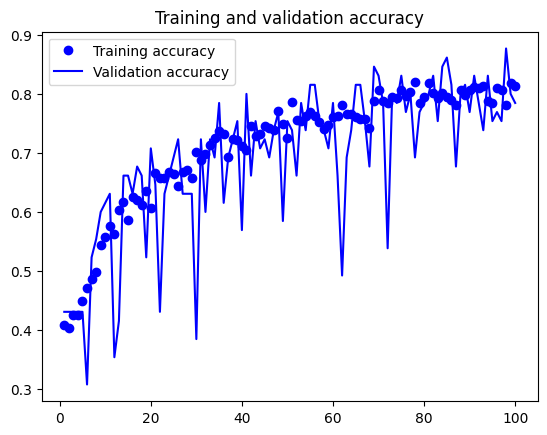

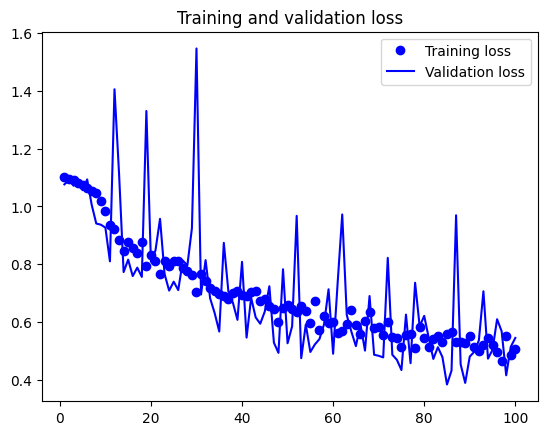

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [7]:
ruta_modelos = "/content/drive/MyDrive/Entrenamientos DL COA 690/Nuevos datos/Modelos optimizados/"
os.chdir(ruta_modelos)
test_model = keras.models.load_model("Modelo Control.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

9/9 [==============================] - 8s 19ms/step - loss: 0.4362 - accuracy: 0.8759
Test accuracy: 0.876


In [8]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

test_predictions = test_model.predict(test_dataset)
test_labels = np.concatenate([labels for _, labels in test_dataset], axis=0)
test_labels = np.argmax(test_labels, axis=1)

9/9 [==============================] - 0s 5ms/step


In [9]:
classes = ["A", "R", "S"]

# Obtener las clases predichas
predicted_classes = np.argmax(test_predictions, axis=1)

# Generar el informe de clasificación
classification_rep = classification_report(test_labels, predicted_classes, target_names = classes)
print(classification_rep)

              precision    recall  f1-score   support

           A       0.79      0.89      0.84        37
           R       0.93      0.93      0.93        41
           S       0.91      0.83      0.87        59

    accuracy                           0.88       137
   macro avg       0.87      0.88      0.88       137
weighted avg       0.88      0.88      0.88       137



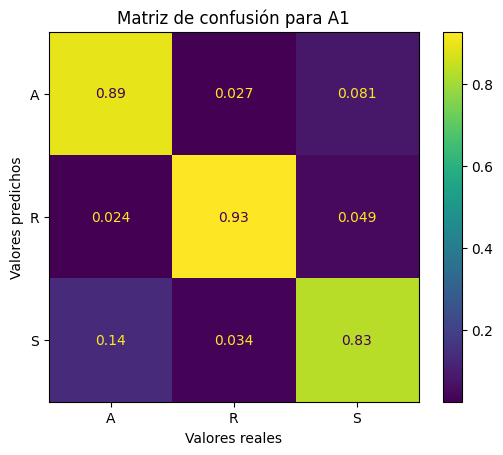

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Calcula la matriz de confusión
confusion = confusion_matrix(test_labels, predicted_classes, normalize = 'true')

display = ConfusionMatrixDisplay(confusion_matrix = confusion,
                                 display_labels = classes)

fig, ax = plt.subplots()
display.plot(ax=ax)
ax.set_title("Matriz de confusión para A1")
ax.set_xlabel("Valores reales")
ax.set_ylabel("Valores predichos")
plt.show()